# Session 2 - Running a cosmological simulation

In the first session we ran a simple, idealised simulation of the merger of two NFW haloes. In this next session the aim is to now run a full cosmological volume that simulates the growth of structure from the early universe ( redshift $z \sim 100$) through to today ($z=0$). By the end of the session you will hopefully have achieved the following:

- Learned about Gaussian random fields, and how these describe the ICs.
- Run a cosmological N-body simulation (optional).
- Understand where cosmology matters in the simulations.
- Begin to visualise and study the outputs of N-body cosmological simulations.

Let's start by importing the modules used throughout this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py as h5

#suppress warnings for divide by zeros
import warnings
warnings.filterwarnings('ignore')

## Gaussian random fields, and the power spectrum

When we observe the cosmic microwave background (CMB) the temperature fluctuation, and corresponding density fluctuations, resemble that of a Gaussian random field. As such, we need to use and understand Guassian random fields to generate the initial conditions for our simulation.

In what follows we will focus on a 2D random field, for simplicity, but the simulations we will run shortly will be in 3D.

Let's begin by generating the simplest form of a Guassian random field. One where there is no spatial correlation between the different fluctuations, this is known as a white noise field. Here each 'pixel' is independently drawn from the same Gaussian distribution.

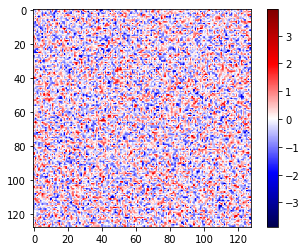

In [2]:
N=128
sigma = np.random.normal(loc=0,scale=1,size=(N,N))

plt.imshow(sigma,cmap='seismic')
plt.colorbar()

In this example we should think of this as mapping to the overdensity field, $\delta(x) = \rho (x)/\rho_m-1$. Here some regions are underdense (negative values) and some are overdense (positive). To describe the statistically averaged form of the density fluctuations it is common to plot the power spectrum, $P(k)$, of the overdensity field. This is essentially just the Fourier transform of the overdensity field. The following function will calculate the fourier power spectrum, plot the density field, a histogram of the overdensities and the power spectrum. Take a look at the code and make sure you understand what is being calculated.

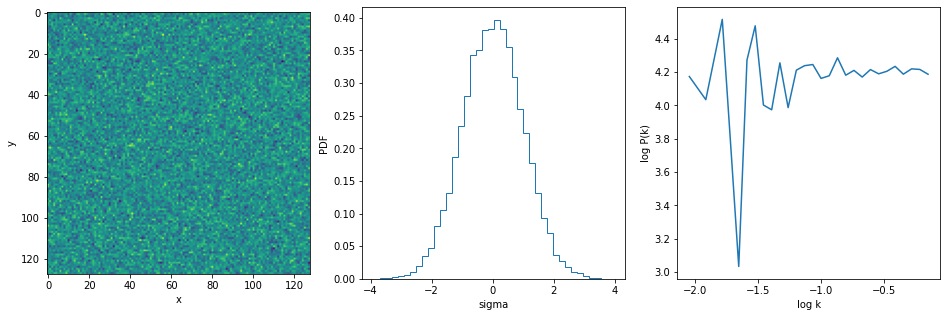

In [3]:
# define a function to plot the density field, the 1d histogram, and the power spectrum
def field_plot(sigma,ft_bins = 30, hist_bins = 40):
    N=sigma.shape[0]
    #calculate ft and power spectrum
    ft = np.fft.fft2(sigma)
    ft_p = np.abs(ft)**2
    
    k_1d = np.fft.fftfreq(N)
    kx,ky = np.meshgrid(k_1d,k_1d)
    k = (kx**2+ky**2)**0.5
    k_log = np.log10(k.flatten()[1:]) #[1:] to ignore k=0
    
    #bin data
    pk,k_bins,_ = stats.binned_statistic(k_log,ft_p.flatten()[1:],statistic='mean',bins=ft_bins)
    
    #now plot
    fig, ax = plt.subplots(1,3,figsize=(16,5))
    
    ax[0].imshow(sigma)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[1].hist(sigma.flatten(),bins = hist_bins,histtype='step',density=True)
    ax[1].set_ylabel('PDF')
    ax[1].set_xlabel('sigma')
    
    cut = np.invert(np.isnan(pk))
    ax[2].plot(k_bins[1:][cut],np.log10(pk[cut]))
    ax[2].set_xlabel('log k')
    ax[2].set_ylabel('log P(k)')
    
    return(fig,ax)

_ = field_plot(sigma)

Here we again see the density field on the left. The middle panel shows the histogram of all overdensities, ignoring any spatial information. Here the overall population is clearly sampled from a Guassian distribution, hence the 'Gaussian' random field.

On the right is the power spectrum for this particular random field. On the x axis is the Fourier mode, where $k^2 = k_x^2 + k_y^2$, while on the y axis is the mean amplitude of the fourier modes at the given k-scale. More formally we would write this as

$P(k) = < \tilde{\delta}(k)\tilde{\delta}^* (k) >$.

The power spectrum describes the size of the density fluctuations at the given scale (remember, small k means large physical scales, and large k small physical scales). In this particular example $P(k) = const$, telling us that there is no spatial correlation in the field. Exactly what is expected for a white noise field. Deviations from constant are purely random, cased by having only a limited number of k-modes in the box.

$P(k)$ is not only a useful way of summarising the information contained within the 2D (or later 3D) density field, but actually completely describes a Guassian field in a statistically averaged way. Hence, by specifying or measuring $P(k)$ we have all of the information about the whole field.

Let's have a look at an example of where there is some structure in the overdensity Gaussian field. We will specifically look at the case where $P(k) \propto k^{-2}$, which is close to what we observe in our own universe.

In the following code we will start with a white noise field. We the modify the FT of the white noise field to match the $P(k)$ that we're interested in (here a power law), and then invert the modified fourier transform to get a Guassian random field with the given power spectrum.

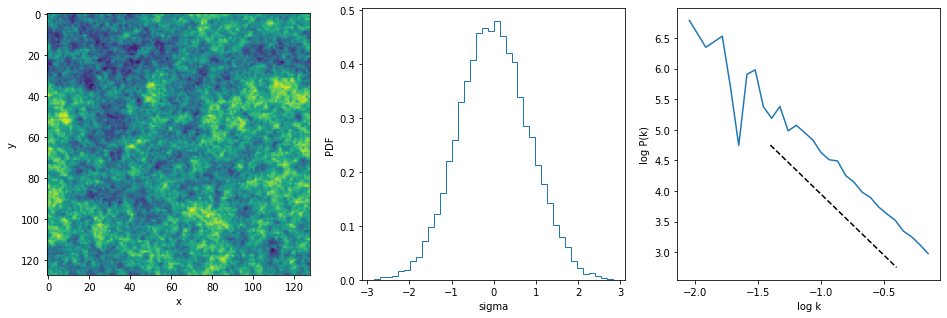

In [4]:
#adjust power spectrum
slope = -2
k_pivot = 10**(-0.8)

#measure the FT to edit in fourier space
ft = np.fft.fft2(sigma)

k_1d = np.fft.fftfreq(N)
kx,ky = np.meshgrid(k_1d,k_1d)
k = (kx**2+ky**2)**0.5

#edit FT to the desired P(k) 
ft_2 = ft*(k/k_pivot)**(slope/2)
ft_2[0,0] = ft[0,0] #deal with zeroing
sigma_2 = np.fft.ifft2(ft_2)

fig,ax = field_plot(np.real(sigma_2))

k=np.linspace(-1.4,-0.4,100)
ax[2].plot(k,slope*k+1.95,'k--')

Here there is now clear structure in the left panel, with large regions of over and underdensities, and structures at all scales. The power spectrum on the right also shows the $P(k) \propto k^{-2}$ dependence (with arbitrary normalisation). Have a mess around with the input power spectrum and see what the effect is on the density field. You can try both changing the slope, or even try a non power law function. (the important line here is just after the '#edit FT to the desired P(k)' comment)

## Initial conditions

Now that we've seen what the form of the initial density field looks like, we'll cover the details of how to make initial conditions for cosmological simulation. First, let's decide on the specific cosmology we want to simulate. Here, we are going to simulate a $\Lambda$CDM cosmology with the Plack 2018 inferred parameters. Specifically, this is:

- $h=0.67321$, the hubble parameter where the Hubble constant is $H_{0} = 100$ $h$ km s$^{-1}$ Mpc$^{-1}$
- $\Omega_m = 0.3158$, ratio of matter
- $\Omega_{\Lambda} = 0.6842$, ratio of dark energy (note $\Lambda$CDM is flat so $\Omega_m + \Omega_{\Lambda} = 1$)
- $\Omega_b = 0.0494$, ratio of baryons
- $n_s = 0.9661$, the scalar spectral index which controls the slope of the power spectrum
- $A_s = 2.1488 \times 10^{-9}$, the spectral amplitude which controls the amplitude of the power spectrum
- $\sigma_8 = 0.8102$, another measure of the amplitude of the power spectrum that is often quoted instead of $A_s$ (you only need either $A_s$ or $\sigma_8$)
- $\rho_{crit} = (3H^2)/(8 \pi G) = 2.78 \times 10^{11} h^2 M_{\odot} Mpc^{-3} = 1.26 \times 10^{11} M_{\odot} Mpc^{-3}$

*Don't worry if you don't recognise all of these parameters.*

The first thing we need is then the power spectra for the given cosmology we want to simulate, which will depend on all of the above parameters. There are a range of codes available to generate the (linear) power spectrum for a $\Lambda$CDM cosmology, with two of the most widely used being [CAMB](https://camb.readthedocs.io/en/latest/) and [CLASS](https://lesgourg.github.io/class_public/class.html), which both now have python implementations as well as standalone C/fortran executables.

Here we have already generated the power spectra of the initial conditions (which will be at $z=127$) that we can look at. The file can be found at `./ICs/input_powerspc.txt`. Let's have a look at what $P(k)$ looks like for this cosmology.

Text(0, 0.5, '$P(k)$')

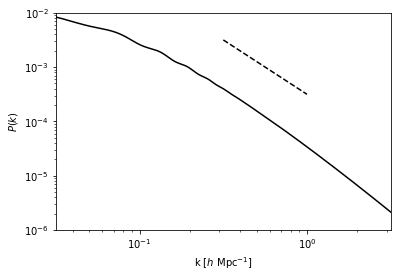

In [5]:
pk = np.loadtxt('./ICs/input_powerspec.txt')
x_sample = np.array([10**-0.5,2])
plt.plot(pk[:,0],pk[:,1],'k-')
plt.plot([10**-0.5,1],10**-3.5*np.array([10**-0.5,1])**-2,'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-1.5,10**0.5)
plt.ylim(10**-6,10**-2)
plt.xlabel('k [$h$ Mpc$^{-1}$]')
plt.ylabel('$P(k)$')

The form of the power spectrum on the right is close to that of the power spectrum we looked at before as can be seen by the $\propto k^{-2}$ line, so the density fluctuations will be similar in form. However the power spectrum is not as simple as a pure power law for a $\Lambda$CDM cosmology. It is overall a smoothly varying power law, getting steeper at large k values. And it additionally has 'wiggles' corresponding to the Baryon Acoustic Oscillations (BAO).

Now that we have the power spectrum for the ICs we need to generate the corresponding density field. The general process is the same as discussed above in the 'Gaussian field' section. We start with a white noise field, and then map this to the particular power spectrum we want. However, what we need to run the simulations, which are gravitational N-body simulations, is not a density field but particle positions. To convert from $\delta (x)$ to a collection of particle positions it is most common to use the Zeldovich approximation, or higher order equivalents such as second order lagrangian perturbation theory (2LPT).

As with generating the power spectrum there are various codes available that will generate the ICs for you, taking care of all the important details. In this session we have pre-generated the ICs for you using [monofonIC]{https://bitbucket.org/ohahn/monofonic/src/master/}, that has `CLASS` integrated within it. While using `monofonIC` is relatively straightforward, it's not the main focus of this summer school. To generate the initial conditions you need to provide the cosmology you want (here we are using Plank 2018 as described above) as well as the properties of the simulation you want to run. Here we are going to run the following simulation:

- Start the simulation at $z=127$
- Box size of $L=25$ $h^{-1}$Mpc (in comoving coordinates)
- Using $N=64^3$ particles (it is common to use a power of 2, here it is $2^{6 \times 3}$)
- This gives a particle mass of $m_p = \Omega_m \rho_c L^3/N = 5.23 \times 10^9 h^{-1} M_{\odot}$

The SWIFT initial conditions can be found at `./ICs/ics_swift.hdf5`. We have also precalculated the power spectrum for these specific ICs in the file `./ICs/PK-DM-ics.txt`.

Let's have a look at the initial particle positions.

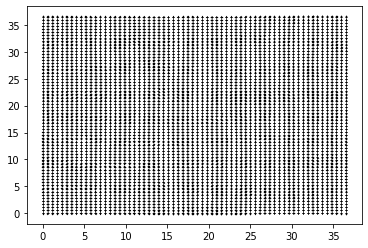

In [6]:
h = h5.File('./ICs/ics_swift.hdf5','r') #read hdf5 file
pos = h['PartType1/Coordinates']

plt.figure()
plt.plot(pos[:,0],pos[:,1],'k.', markersize=0.2)


Here we get a glimpse into how these initial conditions are generated. Initially, particles are placed on a uniform grid, corresponding to a completely smooth universe without any structure. The particle positions (and velocities) are then perturbed from the initial grid according to the particular overdensity field to be simulated, which is specified by the particular cosmology and power spectrum you are wanting to simulate. The displacement of the particles is very small, and you might not even be able to see by eye that any of them have moved. These small displacements correspond to the very small initial density fluctuation. For reference, the temperature fluctuations in the CMB are $~10^{-4} \%$.

We can be more quantitative when describing these density fluctuations and plot the matter power spectrum, and double check it matches what we want for this cosmology.

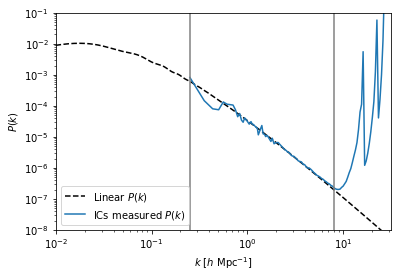

In [7]:
N = 64 #number of particles per dimension
boxsize = 25 #boxsize

h = 0.67321
pk_lin = np.loadtxt('./ICs/input_powerspec.txt')
pk_sim = np.loadtxt('./ICs/PK-DM-ics.txt')

#convert from the units used to measure PK (this is specfic to this file)
pk_sim[:,0] *= 2*np.pi/boxsize 
pk_sim[:,1] *= boxsize**3/(2*np.pi)**3 
         

plt.figure()
plt.plot(pk_lin[:,0],pk_lin[:,1],'k--',label='Linear $P(k)$')
plt.plot(pk_sim[:,0],pk_sim[:,1],label='ICs measured $P(k)$')
#let's also plot the fundametal mode and the nyquist frequncy
k_fund = 2*np.pi/boxsize
k_nyq = (np.pi*N/boxsize)
plt.plot(np.ones(2)*k_fund,np.array([10**-8,10**-1]),color='gray')
plt.plot(np.ones(2)*k_nyq,np.array([10**-8,10**-1]),color='gray')
plt.xscale('log')
plt.yscale('log')

plt.xlim(10**-2,10**1.5)
plt.ylim(10**-8,10**-1)
plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel('$P(k)$')
plt.legend()

Overall, the match between the measured power spectrum (blue) and the specified one (black dashed) is good, with the two lines matching within the scatter. There are two key k-scales to keep in mind here, both related to the size and resolution of the simulation. The first is the fundamental, $k_{fund} = 2 \pi /L$, that is the largest fourier mode that can fit in the box. Any k-values below this (i.e. larger physical scales) are not sampled. Additionally, small k-values near $k_{fund}$ will be very susceptible to cosmic variance, as can be seen by the random deviation from the dashed black line at low k. The other important k-scale is the Nyquist frequency, $k_{nyq} = \pi N/L$. This is the smallest scale that can be sampled for the given resolution. Anything below this is effectively not resolved, and the measured power spectrum deviates strongly from the input.

Increasing either the box size or number of particles, $L$ or $N$, leads to a wider range of the power spectrum to be sampled. However, it is computationally expensive to simulate large volumes at high resolution, so in practice it is not possible to increase $L$ and $N$ to arbitrarily large values. The optimal resolution and box size depends strongly on the given scientific question and computation resources available, and therefore has no easy answer.

If for example you wanted to study the imprint of BAO on galaxy clustering then you would need a large enough box size to adequately sample the BAO scales. Here $L=25 H^{-1} Mpc$ is definitely not sufficient. Similarly if you were interested in studying the evolution of small dwarf galaxies, $M \sim 10^8 M_{\odot}$, then you do not have the resolution needed to do that, with this simulation having a particle mass of $m_p \sim 10^9 M_{\odot}$

## Running the simulation (optional)

With the IC generated we can now run the simulation. The basic process is the same as session 1, however we're now running a different kind of simulation so will need slightly different configuration and parameter files. Everything you need should be set up in the `./simulation` folder of this session's directory.

Let's first look at the submission script that should look like the following:

```
#!/bin/bash -l

./swift --cosmology --self-gravity --power --threads=16 parameter_cosmo.yml
```

The two additional flags added compared to the first session are `--cosmology` and `--power`. The first specifies that this is a cosmological run, while the second turns on the ability for swift to calculate the power spectra on the fly, dumping them alongside the snapshots. We have also now got a new parameter file, `parameter_cosmo.yml`, that contains all the additional parameters needed for this run. This is mainly just the cosmological parameters and properties about the power spectra calculations.

To actually run the simulations you will first need to copy the SWIFT executable into the simulations directory. We can now run the simulation by typing `./submit.sh`. This will take a little while to run, probably 5-10 minutes. Hopefully, this finishes without issue.

Let's have a first look at the simulations by looking at the particle distribution. We will now also use the `swiftsim_io` package that makes interfacing with and analysing swift outputs straightforward and efficient.

Let's start by checking some of the properties of the simulation, such as the box size and number of particles to make sure this is what we wanted.
(*Note: if you are using the preran simulations then edit the `loc` to point to them*)

In [ ]:
import swiftsimio as sw

loc = './simulation/'
data = sw.load(loc+'output/snap_0062.hdf5') #read final snapshot

#check boxsize, particle number, and redshift

print('Boxsize:')
print(data.metadata.boxsize)

print('Particle numbers:')
print(data.metadata.n_dark_matter)

print('Redshift:')
print(data.metadata.redshift)

The first output here (`Could not find gas gamma, assuming 5./3.`) is a warning message from `swiftsim_io` telling us that the hydrodynamic equation for state for the gas has not been specified in the output file, so is assuming $\gamma = 5/3$. As we have run a DM only simulations without any gas this doesn't matter.

Great, we can see that the box size is $25$ $h^{-1}$Mpc $\approx$ $37$ Mpc, there are $2^{6 \times 3}=262144$ particles, and the final snapshot is $z=0$. Now let's read in the particle positions.

In [ ]:
pos = data.dark_matter.coordinates

plt.plot(pos[:,0],pos[:,1],'k.',markersize=0.25,alpha=0.2)
plt.xlim(0,data.metadata.boxsize[0])
plt.ylim(0,data.metadata.boxsize[0])

Here we see the formation of structures in the simulation, with the distribution of particles looking very different to the ICs. In particular we can see very dense collapsed, roughly spherical objects that we refer to as DM haloes. We can also begin to see the structure of the cosmic web, where matter tends to fall into DM haloes along filamentary structure.

While plotting the particle positions as a scatter plot gives us an idea of the structure, it is often better to visualise the distribution by calculating and plotting the surface density. `swiftsim_io` includes a few tools to help us do this, and make a better (and prettier) visualisation of our simulation.

In [ ]:
from swiftsimio.visualisation.projection import project_pixel_grid
from swiftsimio.visualisation.smoothing_length_generation import generate_smoothing_lengths

data.dark_matter.smoothing_length = generate_smoothing_lengths(
    data.dark_matter.coordinates,
    data.metadata.boxsize,
    kernel_gamma=1.8,
    neighbours=57,
)

dm_mass = project_pixel_grid(data=data.dark_matter,boxsize=data.metadata.boxsize,resolution=512,project="masses")
vmin=np.min(np.log(dm_mass))
vmax=np.max(np.log(dm_mass))

fig=plt.figure(figsize=(10,10)) 
plt.imshow(np.log(np.flip(dm_mass.transpose(),axis=0)),cmap='inferno') #flip and transpose used to make pixel coordinates same as particle positions

The structure within the simulation is now much clearer, where both the individual haloes and cosmic web can clearly be seen.

Let's now look at the redshift evolution of the structure, where we can observe the growth of structure over time.

In [ ]:
n_plot = 10
n_cols = 5
n_row = n_plot//n_cols + (n_plot%n_cols >0)

min_snap = 40
max_snap = 62

snap_numbers = np.linspace(min_snap,max_snap,n_plot)

fig,ax = plt.subplots(n_row,n_cols,figsize=(16,8))

k=0
for i in range(n_row):
    for j in range(n_cols):
        
        data = sw.load(loc+'output/snap_%04d.hdf5'%(int(snap_numbers[k])))
        data.dark_matter.smoothing_length = generate_smoothing_lengths(data.dark_matter.coordinates,data.metadata.boxsize,kernel_gamma=1.8,neighbours=57)
        dm_mass = project_pixel_grid(data=data.dark_matter,boxsize=data.metadata.boxsize,resolution=512,project="masses")
        
        ax[i,j].imshow(np.log(np.flip(dm_mass.transpose(),axis=0)),cmap='inferno',vmin=vmin,vmax=vmax)
        
        ax[i,j].text(0.05,0.05,'$z=%.1f$'%data.metadata.redshift,color='white',transform=ax[i,j].transAxes)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k+=1
plt.subplots_adjust(wspace=0, hspace=0)


Here the evolution of structure is clear. The universe starts in a relatively smooth state which we saw in the ICs before structures continue to grow and collapse, particularly through successive mergers of DM haloes. This results in both the overdensities becoming denser (more red and bright in the colormap), as well as the underdensities becoming more underdense (more black and darker in the colormap).

We can be a bit more quantitative in describing the evolution of structure by looking at the power spectrum over time.

In [ ]:
boxsize=25/h
N=64
k_fund = 2*np.pi/boxsize
k_nyq = (np.pi*N/boxsize)

n_plot = 5
min_snap = 40
max_snap = 62
snap_numbers = np.linspace(min_snap,max_snap,n_plot)

#plot power spectra
z = []
plt.figure()
for i in range(n_plot):
    data = sw.load(loc+'output/snap_%04d.hdf5'%(int(snap_numbers[i])))
    pk = np.loadtxt(loc+'power_spectra/power_matter_%04d.txt'%int(snap_numbers[i]))
    plt.plot(pk[:,1],pk[:,2],label='z=%.1f'%data.metadata.redshift)
    
    z.append(data.metadata.redshift)
    
#plot fundament and nyquist frequencies
plt.plot(np.ones(2)*k_fund,[10**-4,10**3.7],'--',color='gray')
plt.plot(np.ones(2)*k_nyq*4,[10**-4,10**3.7],'--',color='gray') #multiplied by 4 due to the 'folding'
plt.xlabel('$k$ [Mpc$^{-1}$]')
plt.ylabel('$P(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()


The amplitude of the power spectrum, which can crudely be interpreted as the size of the density fluctuations at a specific scale, clearly evolves with redshift. In general $P(k)$ increases over time, reflecting the growth of structures in the simulation (and our Universe). From $z \sim 4$ to $z \sim 0$ there is roughly an order of magnitude increase in $P(k)$.

One key thing to keep in mind when discussing the distribution of matter beyond the very early universe is that it is now ***not*** a Guassian random field. The collapse of structures due to gravity is a non-Guassian process. As such, the power spectrum no longer completely describes the density field, like it did for the ICs. There is therefore more information contained in higher order statistics such as the bi-spectrum or more direct classifications of the density field into the constituents of the cosmic web (i.e. voids, filaments, walls/sheets, and knots). How to best extract and analyse this additional information is an open question in cosmology with many different ideas and methods being actively studied.

While $P(k)$ no longer offers a complete description of the distribution of matter it is still a very useful statistic to study and is used extensively throughout the field.

## Extensions

- Generate new initial conditions for a different cosmology and run that, compare what the outputs look like. Maybe try an Einstein de Sitter (EdS) universe, $\Omega_k = \Omega_{\Lambda} = 0$. (*Note: to do this you will need to download and install Monofonic yourself*)
- Make a movie. Use swiftsim_io to generate images for each snapshot (as we did above), then combine these into a movie using `ffmpeg`.
- Start Session 3, this is a lot more open ended with more content than you will be able to get through in one session.